# Import Library

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from keras.callbacks import Callback

# Define Constants

In [ ]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Mount Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare Traning Data

In [ ]:
filenames = os.listdir("/content/drive/MyDrive/data")
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'thob':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df.head()

,filename,category
0,notthob-65.jpg,0
1,notthob-72.jpg,0
2,notthob-85.jpg,0
3,notthob-66.jpg,0
4,notthob-76.jpg,0


In [ ]:
df.tail()

,filename,category
163,thob-53.jpg,1
164,thob-1.jpg,1
165,thob-52.jpg,1
166,thob-51.jpg,1
167,thob-50.jpg,1


### See Total In count

<Axes: >

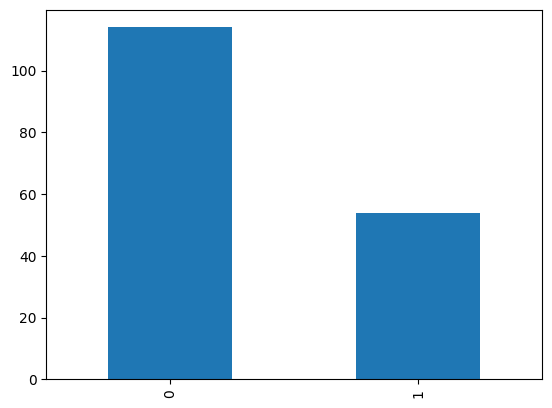

In [ ]:
df['category'].value_counts().plot.bar()

From our data we have 54 thob wearer and 114 not thob wearer



# See sample image

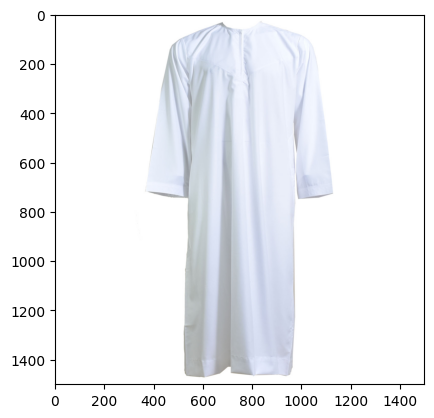

In [ ]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/data/"+sample)
plt.imshow(image)

# Build Model

* **Input Layer**: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layerreduce the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have thob and not thob classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_20 (Bat  (None, 126, 126, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_21 (Bat  (None, 61, 61, 64)      

# Callbacks

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [ ]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
callbacks = [earlystop, learning_rate_reduction]

# Prepare data

Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to thob and 0 to notthob

In [ ]:
df["category"] = df["category"].replace({0: 'notthob', 1: 'thob'})

In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: >

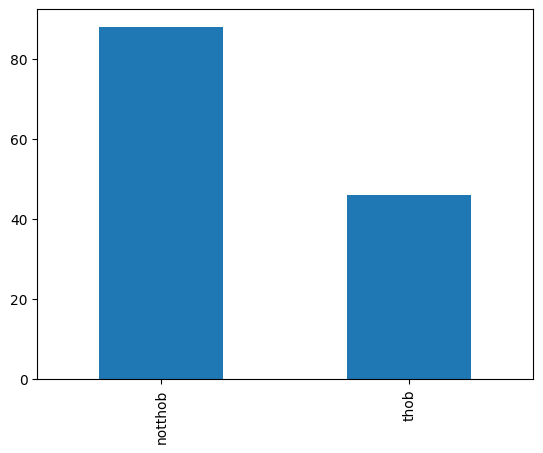

In [ ]:
train_df['category'].value_counts().plot.bar()

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

NameError: ignored

# Traning Generator

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/drive/MyDrive/data",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 134 validated image filenames belonging to 2 classes.


### Validation Generator

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/drive/MyDrive/data",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 34 validated image filenames belonging to 2 classes.


# See how our generator work

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/content/drive/MyDrive/data",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


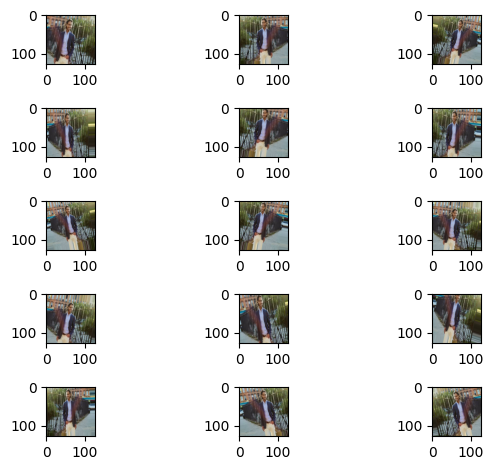

In [ ]:
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Seem to be nice

# Fit Model

In [ ]:
class CompleteEpochsCallback(Callback):
    def __init__(self, total_epochs):
        self.total_epochs = total_epochs

    def on_epoch_end(self, epoch, logs=None):
        if epoch + 1 >= self.total_epochs:
            self.model.stop_training = True

# Set the total epochs based on FAST_RUN
total_epochs = 3 if FAST_RUN else 50

# Initialize the CompleteEpochsCallback
complete_epochs_callback = CompleteEpochsCallback(total_epochs)

# Use the callback during training
history = model.fit(
    train_generator,
    epochs=total_epochs,
    validation_data=validation_generator,
    validation_steps=total_validate // batch_size,
    steps_per_epoch=total_train // batch_size,
    callbacks=[callbacks, complete_epochs_callback]
)

Epoch 1/50
8/8 [==============================] - 11s 1s/step - loss: 1.0164 - accuracy: 0.7983 - val_loss: 2.6537 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 2/50
8/8 [==============================] - 9s 1s/step - loss: 0.2705 - accuracy: 0.8833 - val_loss: 3.3672 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 0.3211 - accuracy: 0.9000
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
8/8 [==============================] - 10s 1s/step - loss: 0.3211 - accuracy: 0.9000 - val_loss: 4.3882 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 4/50
8/8 [==============================] - 10s 1s/step - loss: 0.2522 - accuracy: 0.9328 - val_loss: 2.8355 - val_accuracy: 0.3667 - lr: 5.0000e-04
Epoch 5/50
8/8 [==============================] - 9s 1s/step - loss: 0.3866 - accuracy: 0.9160 - val_loss: 1.7549 - val_accuracy: 0.4667 - lr: 5.0000e-04
Epoch 6/50
8/8 [==============================] - 9s 1s/step - loss: 0.1953 - accu

# Save Model

In [ ]:
model.save_weights("model.h5")
model.save("model1.h5")

# Virtualize Training

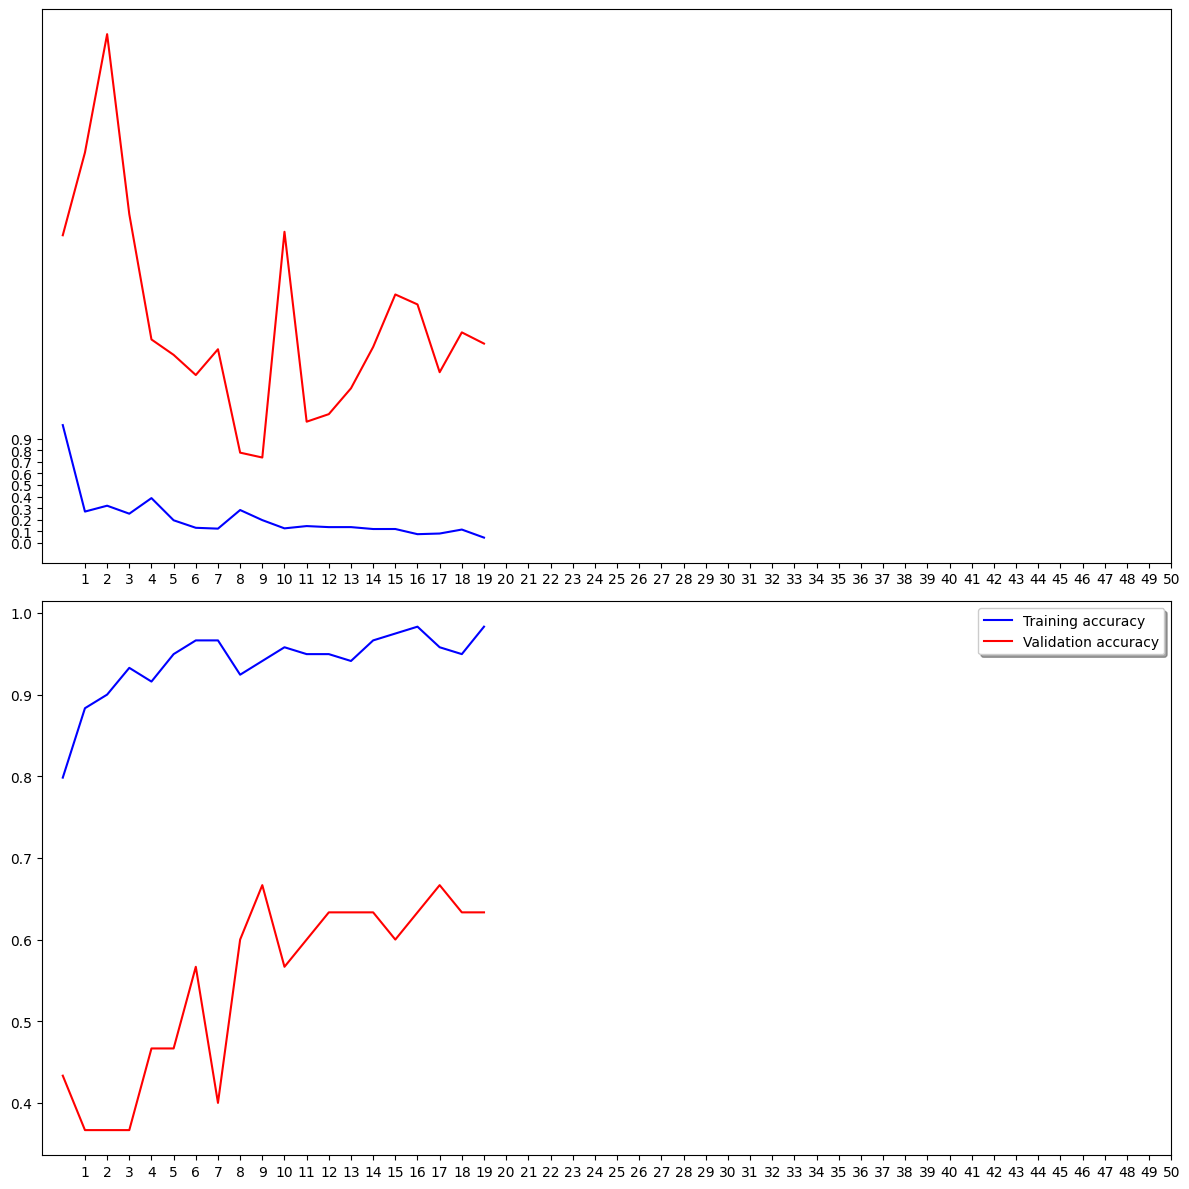

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, total_epochs + 1, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, total_epochs + 1, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [ ]:
test_filenames = os.listdir("/content/drive/MyDrive/testdata")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "/content/drive/MyDrive/testdata",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 6 validated image filenames.


# Predict

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-41-52619fd72ccc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using `train_generator.class_indices`. It is the classes that image generator map while converting data into computer vision

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our prepare data part. We map data with `{1: 'thob', 0: 'not thob'}`. Now we will map the result back to thob is 1 and not thob is 0

In [ ]:
test_df['category'] = test_df['category'].replace({ 'thob': 1, 'notthob': 0 })

### Virtaulize Result

<Axes: >

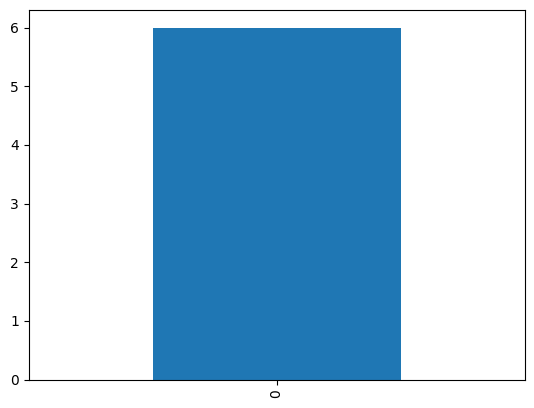

In [ ]:
test_df['category'].value_counts().plot.bar()

### See predicted result with images

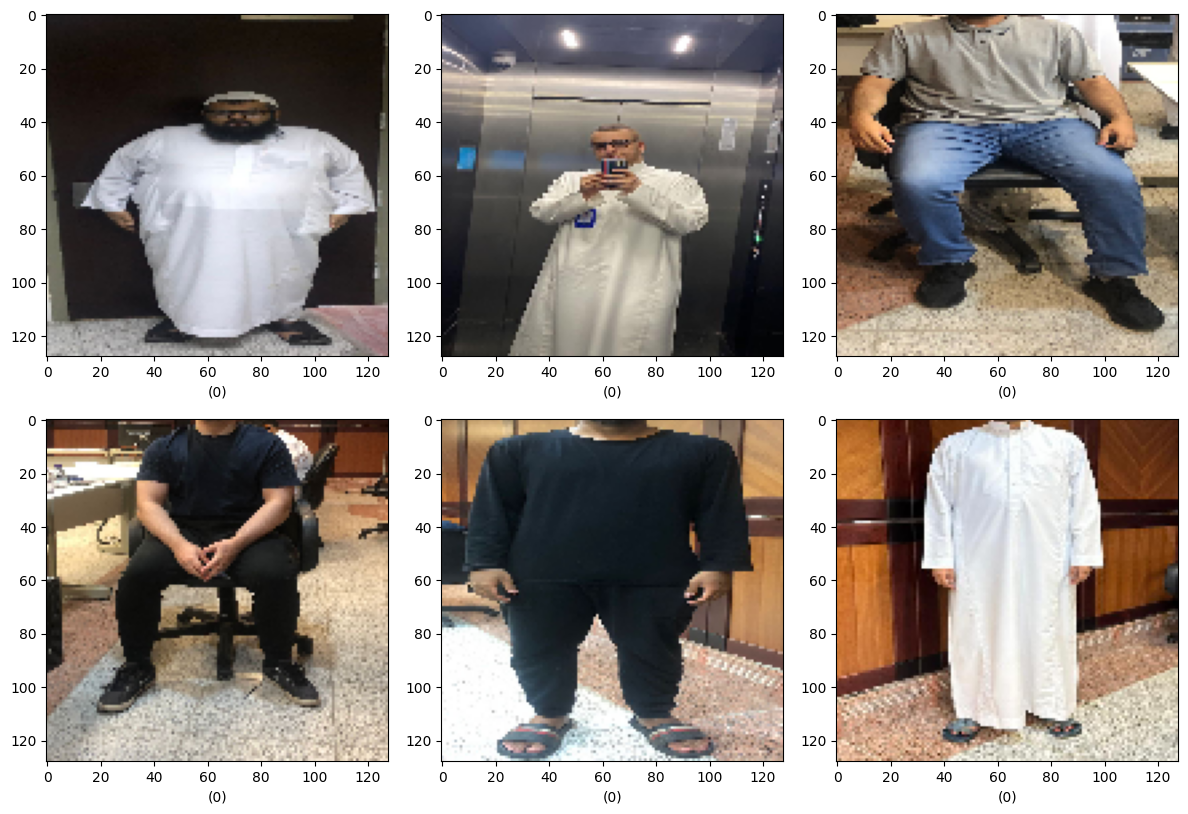

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/drive/MyDrive/testdata/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel('(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Submission

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)